Training on 4000 meters. Testing on 1000 meters.
Training model...
Training complete.
------------------------------------------------
Model Performance:
RMSE: 0.5702 m/hr (Average Error)
R2 Score: 0.8593 (Accuracy 0 to 1)
------------------------------------------------


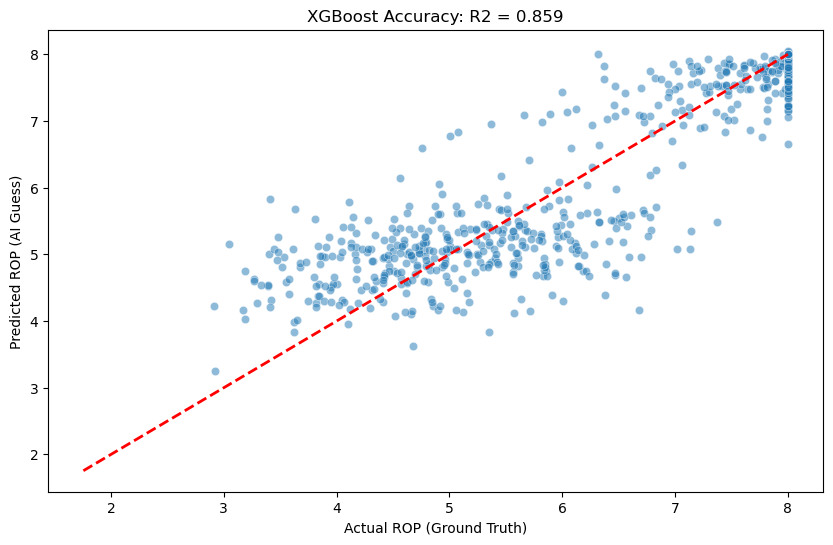

In [13]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap

NB_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NB_DIR)
RAW_DATA_DIR = os.path.join(PROJECT_ROOT, 'data', 'raw')
os.makedirs(RAW_DATA_DIR, exist_ok=True)
FIGURES_DIR = os.path.join(PROJECT_ROOT,'data', 'reports', 'figures')
os.makedirs(FIGURES_DIR, exist_ok=True)
csv_path =  os.path.join(RAW_DATA_DIR, 'raw_tunnel_data.csv')

df = pd.read_csv(csv_path)

# we have multiple parameters here unlike M1 so we do
# some ways: features = ['UCS_MPa', 'RQD_pct', 'Thrust_kN', 'RPM']
# X = df[features]

# use list here and if we only say drop rop_m_hr but give it true rop we give it the ans, remove all rop
X = df.drop(columns=['ROP_m_hr', 'True_ROP']).copy()
y =  df['ROP_m_hr']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

print(f"Training on {len(X_train)} meters. Testing on {len(X_test)} meters.")

model = xgb.XGBRegressor( # the paramerts value are just starting point, we run 'grid search' to find the best combo
    n_estimators=100, # no of interns (trees)
    learning_rate = 0.1, #how fast they learn (small to avoid ovvereacting)
    max_depth=5, # how complex each tree can be, might fail on new data
    random_state=42,
    n_jobs=-1 #use all cpu cores
)

print("Training model...")
model.fit(X_train, y_train)
print("Training complete.")
y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred) #does order matter here??

print(f"------------------------------------------------")
print(f"Model Performance:")
print(f"RMSE: {rmse:.4f} m/hr (Average Error)")
print(f"R2 Score: {r2:.4f} (Accuracy 0 to 1)")
print(f"------------------------------------------------")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2) # The Perfect Prediction Line
plt.xlabel('Actual ROP (Ground Truth)')
plt.ylabel('Predicted ROP (AI Guess)')
plt.title(f'XGBoost Accuracy: R2 = {r2:.3f}')
plt.show()




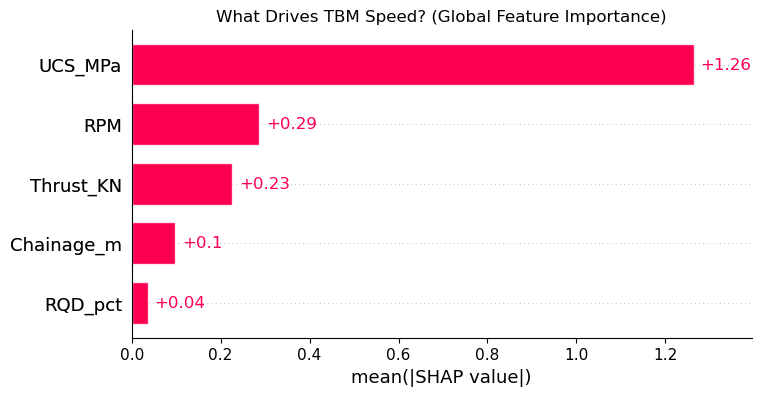

<Figure size 640x480 with 0 Axes>

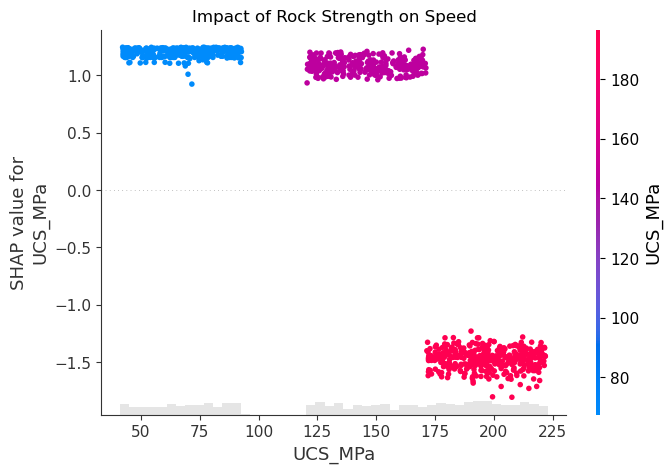

<Figure size 640x480 with 0 Axes>

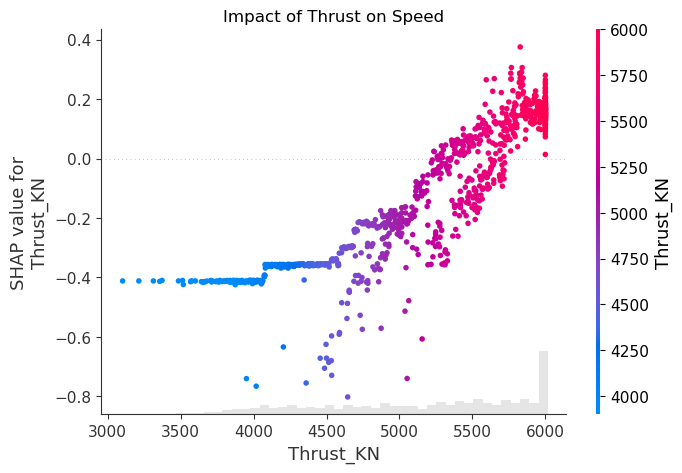

In [14]:
#using shap now

try:
    explainer = shap.TreeExplainer(model) # to look inside the decision trees of xgb
except Exception as e: # version conflict, xgb and shap not working proper, downgrade to 1.7.6
    print("direct model pass failed. Trying booster extraction:..")
    explainer = shap.TreeExplainer(model.get_booster())

shap_values = explainer(X_test)

# 3. GLOBAL IMPORTANCE (The Big Picture)
# Which variable matters most? UCS? Thrust?
plt.figure()
shap.plots.bar(shap_values, max_display=10, show=False)
plt.title("What Drives TBM Speed? (Global Feature Importance)")
plt.show()

# 4. THE PHYSICS CHECK (Dependency Plots)
# We want to see the DIRECTION. Does High UCS push prediction DOWN?

# Plot A: UCS vs SHAP Value
# X-axis: Rock Strength (UCS)
# Y-axis: Impact on Speed (SHAP value)
plt.figure()
# right 'y axis' is just color value
shap.plots.scatter(shap_values[:, "UCS_MPa"], color=shap_values[:, "UCS_MPa"], show=False) # not to show auto, but call by using plt.show()
plt.title("Impact of Rock Strength on Speed")
plt.show()
# If the dots go DOWN as X goes RIGHT, the model learned physics.

# Plot B: Thrust vs SHAP Value
plt.figure()
shap.plots.scatter(shap_values[:, "Thrust_KN"], color=shap_values[:, "Thrust_KN"], show=False)
plt.title("Impact of Thrust on Speed")
plt.show()
# If the dots go UP as X goes RIGHT, the model learned physics.